In [1]:
# basic modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from pprint import pprint

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score 
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix

# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier

#settings
warnings.filterwarnings('ignore')
rs = 42
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
c = StratifiedKFold(n_splits=3)

In [2]:
df = pd.read_csv('./data/mimic_premodel.csv')

# Scaling and Train/Test-Split

In [3]:
X = df.iloc[:, 1:]
y = df.label

In [4]:
X.head()

,age,numb_diagn,los,tracheo,PaO2,base_excess,creatinin,hb,pH,FiO2,...,leuko,mean_insp_pr,resp_rat,tidal_vol,breath_min_vol,ismale,icu_CSRU,icu_MICU,icu_SICU,icu_TSICU
0,56.0,11,6.1731,1,86.0,2.0,1.1,10.3,7.43,35.000000,...,10.7,6.0,18.0,653.0,11.754,1,0,1,0,0
1,28.0,8,0.6924,0,171.0,4.0,0.8,14.3,7.52,40.000001,...,9.3,6.4,20.0,430.0,8.600,1,0,1,0,0
2,37.0,26,10.5061,0,39.0,10.0,1.1,14.0,7.41,70.000000,...,17.2,6.0,16.0,151.0,2.416,1,0,1,0,0
3,46.0,11,1.6501,0,365.0,2.0,1.0,14.0,7.39,50.000000,...,8.4,1.0,18.0,441.0,7.938,1,0,1,0,0
4,57.0,18,3.7287,0,143.0,5.0,0.7,15.2,7.47,30.000000,...,8.5,7.0,17.0,481.0,8.177,1,0,0,0,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs, stratify=y)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 4377 samples.
Testing set has 1459 samples.


In [6]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Functions

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Dummy Classifier

In [8]:
dumm = DummyClassifier(strategy= "stratified", random_state=rs)
dumm.fit(X_train, y_train)
y_pred_dumm = dumm.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred_dumm)
np.set_printoptions(precision=2)

print(classification_report(y_test, y_pred_dumm))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_dumm, beta=0.5 ):.2f}')


              precision    recall  f1-score   support

           0       0.36      0.36      0.36       508
           1       0.66      0.66      0.66       951

    accuracy                           0.56      1459
   macro avg       0.51      0.51      0.51      1459
weighted avg       0.56      0.56      0.56      1459

F-Beta-Score(0.5) =  0.66


Confusion matrix, without normalization
[[185 323]
 [325 626]]


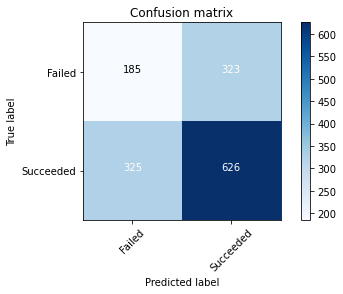

In [9]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

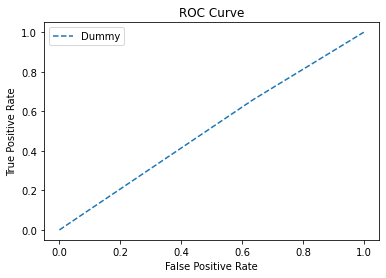

AUC(Dummy) = 0.51


In [10]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dumm)
plt.plot(fpr, tpr, linestyle='--',label="Dummy") 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_dumm_prob = dumm.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")

# Base Model

zuerst Standardeinstellungen für die Hyperparameter, danach Hyperparameter-Tuning (Random- und Grid-Search)

logistic regression (Jacqueline)  
decision tree (Nina)   
random forest (Nina)  
XGBoost (Niko)  
AdaBoost (Niko)  
SVM (Mirko)   
kNN (Mirko)   
Naive Bayes (Jacqueline) 

## Logistic Regression

### Hyperparameter by default

In [11]:
lr = LogisticRegression(random_state=rs)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [12]:
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.59      0.26      0.36       508
           1       0.70      0.90      0.79       951

    accuracy                           0.68      1459
   macro avg       0.64      0.58      0.57      1459
weighted avg       0.66      0.68      0.64      1459

F-Beta-Score(0.5) =  0.73


Confusion matrix, without normalization
[[131 377]
 [ 91 860]]


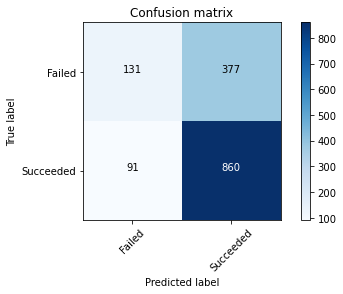

In [13]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

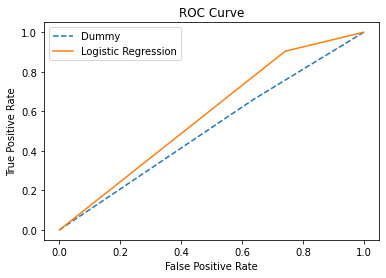

AUC(Dummy) = 0.51
AUC(logReg)= 0.69


In [14]:
# Plot the ROC curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_prob = lr.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")

### Hyperparameter tuning

In [15]:
# Hyperparameter grid for RandomSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [100, 10, 1, 0.1, 0.01] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = fhalf_scorer, cv = c, 
                        n_iter = 100, verbose = 1, random_state=rs)

# Fit 
lr_rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   11.9s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LogisticRegression(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none']},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5),
                   verbose=1)

In [16]:
lr_rs.best_params_

{'penalty': 'l2', 'C': 1}

In [17]:
best_model_lr_rs = lr_rs.best_estimator_

In [18]:
# Hyperparameter grid for GridSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [5, 4, 3, 2, 1 , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_gs = GridSearchCV(estimator, param_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
lr_gs.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 177 out of 192 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    0.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [5, 4, 3, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3,
                               0.2, 0.1, 0.09, 0.08],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [19]:
lr_gs.best_params_

{'C': 0.2, 'penalty': 'l2'}

In [20]:
best_model_lr_gs = lr_gs.best_estimator_

In [21]:
y_pred_lr_best = best_model_lr_gs.predict(X_test)
print(classification_report(y_test, y_pred_lr_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.59      0.25      0.35       508
           1       0.69      0.90      0.79       951

    accuracy                           0.68      1459
   macro avg       0.64      0.58      0.57      1459
weighted avg       0.66      0.68      0.64      1459

F-Beta-Score(0.5) =  0.73


Confusion matrix, without normalization
[[129 379]
 [ 91 860]]


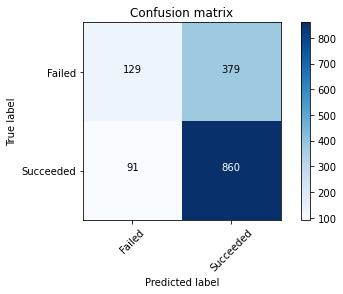

In [22]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

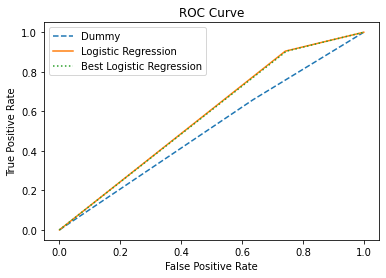

AUC(Dummy) = 0.51
AUC(logReg)= 0.69
AUC(BestlogReg)= 0.69


In [23]:
# Plot the ROC curve
fpr_lr_best, tpr_lr_best, thresholds_lr_best = roc_curve(y_test, y_pred_lr_best)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.plot(fpr_lr_best, tpr_lr_best, linestyle=':', label='Best Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_best_prob = best_model_lr_gs.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")
print(f"AUC(BestlogReg)= {roc_auc_score(y_test, y_pred_lr_best_prob[:,1]):.2f}")

## Decision Tree 

In [24]:
dtree_clf_base = DecisionTreeClassifier(random_state=rs)
dtree_clf_base.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [25]:

y_pred_dtree_clf_base = dtree_clf_base.predict(X_test)

#### Evaluate Base Model

In [26]:
print(classification_report(y_test, y_pred_dtree_clf_base))
print(confusion_matrix(y_test, y_pred_dtree_clf_base))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_dtree_clf_base, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.38      0.39      0.39       508
           1       0.67      0.66      0.67       951

    accuracy                           0.57      1459
   macro avg       0.53      0.53      0.53      1459
weighted avg       0.57      0.57      0.57      1459

[[199 309]
 [321 630]]
F-Beta-Score(0.5) =  0.67


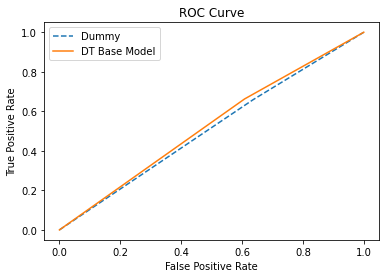

AUC(Dummy) = 0.51
AUC(BaseModel)= 0.53


In [27]:
# ROC Curve Base Model and Dummy
fpr_dt_bm, tpr_dt_bm, thresholds_dt_bm = roc_curve(y_test, y_pred_dtree_clf_base)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_dt_bm, tpr_dt_bm, linestyle='-', label='DT Base Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_dtree_clf_base = dtree_clf_base.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_dtree_clf_base[:,1]):.2f}")

In [28]:
# Look at parameters used by our current decision tree
print('Parameters currently in use:\n')
pprint(dtree_clf_base.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}


### Random Search

In [29]:
# Set scorer for random search to f-beta 0.5
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [30]:
# set cross-validation to a stratified split of 3
c_strat=StratifiedKFold(n_splits=3)

In [32]:
# Maximum number of levels in tree
max_depth=[int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split=[2, 5, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf=[1, 2, 4, 6, 8]

# Number of features to consider at every split
max_features=['auto', 'sqrt']

# Create the random grid
random_grid_dt = {
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
                }
pprint(random_grid_dt)
#'max_depth': max_depth

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6, 8],
 'min_samples_split': [2, 5, 10, 20]}


In [33]:
# Random search of parameters, using 3 fold cross validation 
dt_random = RandomizedSearchCV(estimator = dtree_clf_base, param_distributions = random_grid_dt, 
                               scoring=fhalf_scorer, n_iter = 100, cv = c_strat, verbose=2, 
                               random_state=rs, n_jobs = -1)

In [34]:
dt_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.5s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5),
                   verbose=2)

In [35]:
dt_random.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10}

In [36]:
y_pred_dt_random = dt_random.predict(X_test)

### Grid Search

In [37]:
# Create the parameter grid based on the results of random search 
param_grid = {
     'min_samples_split': [1, 2, 3, 4],
     'min_samples_leaf': [1, 2, 3, 4],
     'max_features': ['sqrt', 'auto'],
     'max_depth': [5, 10, 15, 20]
}

In [38]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dtree_clf_base, param_grid = param_grid, scoring=fhalf_scorer, 
                           cv = c_strat, n_jobs = -1, verbose = 2)

In [39]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    1.3s finished


{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [40]:
y_pred_dt_grid = grid_search.predict(X_test)

#### Evaluate Grid Search

In [41]:
print(classification_report(y_test, y_pred_dt_grid))
print(confusion_matrix(y_test, y_pred_dt_grid))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_dt_grid, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.44      0.32      0.37       508
           1       0.68      0.79      0.73       951

    accuracy                           0.62      1459
   macro avg       0.56      0.55      0.55      1459
weighted avg       0.60      0.62      0.61      1459

[[161 347]
 [202 749]]
F-Beta-Score(0.5) =  0.70


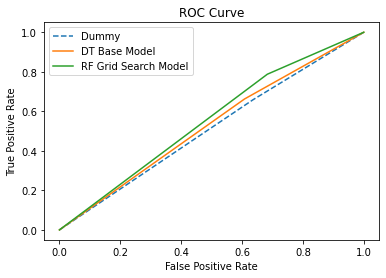

AUC(Dummy) = 0.51
AUC(BaseModel)= 0.53
AUC(GridSearch)= 0.60


In [42]:
# ROC Curve Random Search Model, Base Model and Dummy
fpr_dt_gs, tpr_dt_gs, thresholds_dt_gs = roc_curve(y_test, y_pred_dt_grid)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_dt_bm, tpr_dt_bm, linestyle='-', label='DT Base Model')
plt.plot(fpr_dt_gs, tpr_dt_gs, linestyle='-', label='RF Grid Search Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_dt_random = dt_random.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_dtree_clf_base[:,1]):.2f}")
print(f"AUC(GridSearch)= {roc_auc_score(y_test, y_proba_dt_random[:,1]):.2f}")

## Random Forest

### Base Model

In [43]:
rf_clf_base = RandomForestClassifier(random_state=rs)
rf_clf_base.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [44]:
y_pred_rf_clf_base = rf_clf_base.predict(X_test)

#### Evaluate Base Model

In [45]:
print(classification_report(y_test, y_pred_rf_clf_base))
print(confusion_matrix(y_test, y_pred_rf_clf_base))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_clf_base, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.59      0.31      0.41       508
           1       0.71      0.88      0.78       951

    accuracy                           0.68      1459
   macro avg       0.65      0.60      0.60      1459
weighted avg       0.66      0.68      0.65      1459

[[159 349]
 [112 839]]
F-Beta-Score(0.5) =  0.74


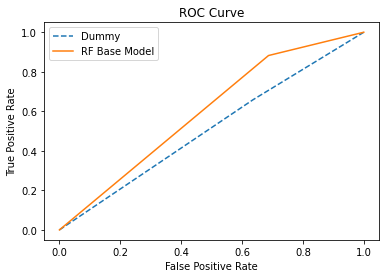

AUC(Dummy) = 0.51
AUC(BaseModel)= 0.67


In [46]:
# ROC Curve Base Model and Dummy
fpr_rf_bm, tpr_rf_bm, thresholds_rf_bm = roc_curve(y_test, y_pred_rf_clf_base)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_clf_base = rf_clf_base.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")

In [47]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_clf_base.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Random Search

In [48]:
# Set scorer for random search to f-beta 0.5
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [49]:
# set cross-validation to a stratified split of 3
c_strat=StratifiedKFold(n_splits=3)

In [50]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [51]:
# Random search of parameters, using 3 fold cross validation 
rf_random = RandomizedSearchCV(estimator = rf_clf_base, param_distributions = random_grid, scoring=fhalf_scorer, 
                               n_iter = 100, cv = c_strat, verbose=2, random_state=rs, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=

In [52]:
rf_random.best_params_

{'n_estimators': 1788,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

### Grid Search

In [53]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3, 4],
    'n_estimators': [1000, 1500, 2000]
}

In [54]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_clf_base, param_grid = param_grid, scoring=fhalf_scorer, 
                           cv = c_strat, n_jobs = -1, verbose = 2)

In [55]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 170.4min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 181.6min finished


{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [56]:
y_pred_rf_clf_grid = grid_search.predict(X_test)

#### Evaluate Grid Search

In [57]:
print(classification_report(y_test, y_pred_rf_clf_grid))
print(confusion_matrix(y_test, y_pred_rf_clf_grid))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_clf_grid, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.59      0.31      0.41       508
           1       0.71      0.88      0.79       951

    accuracy                           0.69      1459
   macro avg       0.65      0.60      0.60      1459
weighted avg       0.67      0.69      0.65      1459

[[159 349]
 [110 841]]
F-Beta-Score(0.5) =  0.74


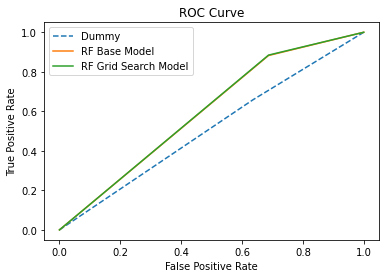

AUC(Dummy) = 0.51
AUC(BaseModel)= 0.67
AUC(GridSearch)= 0.68


In [58]:
# ROC Curve Random Search Model, Base Model and Dummy
fpr_rf_gs, tpr_rf_gs, thresholds_rf_gs = roc_curve(y_test, y_pred_rf_clf_grid)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.plot(fpr_rf_gs, tpr_rf_gs, linestyle='-', label='RF Grid Search Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_clf_random = rf_random.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")
print(f"AUC(GridSearch)= {roc_auc_score(y_test, y_proba_rf_clf_random[:,1]):.2f}")

## XGBoost

In [59]:
# instanciate classifier, fit model
xgboost = XGBClassifier(random_state=rs)
xgboost.fit(X_train, y_train)

XGBClassifier(random_state=42)

In [60]:
y_pred_xgb = xgboost.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.60      0.32      0.42       508
           1       0.71      0.89      0.79       951

    accuracy                           0.69      1459
   macro avg       0.66      0.60      0.60      1459
weighted avg       0.67      0.69      0.66      1459



In [62]:
fbeta_score(y_test, y_pred_xgb, beta=0.5)

0.738765518447281

Text(0.5, 1.0, 'Confusion matrix')

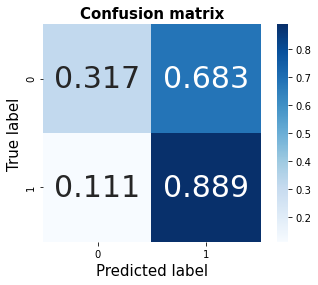

In [63]:
cm = confusion_matrix(y_test, xgboost.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

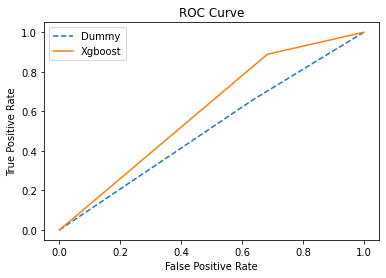

AUC(Dummy) = 0.51
AUC(Xgboost)= 0.69


In [64]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = xgboost.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

### random search

In [65]:
xgb_grid = dict()
xgb_grid['max_depth'] = [2, 3, 4, 5, 6]
xgb_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
xgb_grid['gamma'] = [0,0.1,0.2,0.3,0.4,0.5]

model = XGBClassifier()
grid = xgb_grid
    
# run randomized search and optimize for fhalf_scorer
clf = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs,cv=c)
search = clf.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   14.8s finished


In [66]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.36      0.45       508
           1       0.72      0.87      0.79       951

    accuracy                           0.69      1459
   macro avg       0.66      0.62      0.62      1459
weighted avg       0.68      0.69      0.67      1459



In [67]:
print(search.best_params_)

{'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5}


best result: {'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5}

In [68]:
y_pred_xgb_rdm = clf.predict(X_test)

In [69]:
fbeta_score(y_test, y_pred_xgb_rdm, beta=0.5)

0.7451191115887517

Text(0.5, 1.0, 'Confusion matrix')

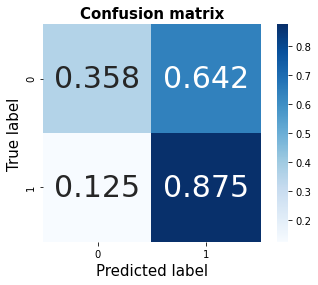

In [70]:
cm = confusion_matrix(y_test, clf.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

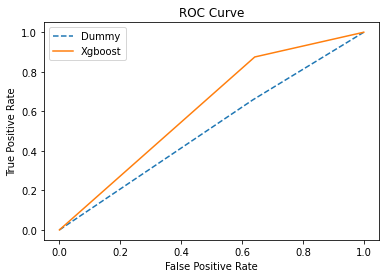

AUC(Dummy) = 0.51
AUC(Xgboost)= 0.69


In [71]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_lr = roc_curve(y_test, y_pred_xgb_rdm)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = clf.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

### Gridsearch

In [72]:
param_grid = {
    'max_depth': [2,3,4],
    'learning_rate': [0.2, 0.15, 0,25],
    'gamma': [0.5, 0.55, 0.45],}

optimal_params = GridSearchCV(
    estimator= XGBClassifier(), cv=c,
    param_grid=param_grid,
     scoring = fhalf_scorer)## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 4}


{'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 4}

In [73]:
y_pred_xgb_grid = optimal_params.predict(X_test)

In [74]:
print(classification_report(y_test, y_pred_xgb_grid))

              precision    recall  f1-score   support

           0       0.59      0.37      0.46       508
           1       0.72      0.86      0.79       951

    accuracy                           0.69      1459
   macro avg       0.66      0.62      0.62      1459
weighted avg       0.68      0.69      0.67      1459



In [75]:
fbeta_score(y_test, y_pred_xgb_grid, beta=0.5)

0.7448738885864635

Text(0.5, 1.0, 'Confusion matrix')

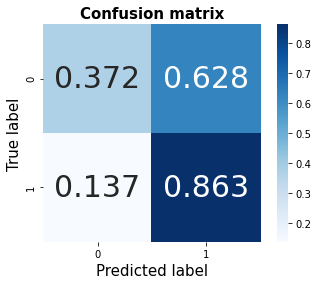

In [76]:
cm = confusion_matrix(y_test, optimal_params.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

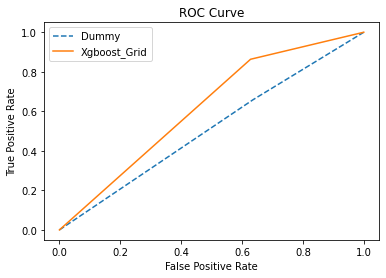

AUC(Dummy) = 0.51
AUC(Xgboost)= 0.69


In [77]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_grid)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost_Grid')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = optimal_params.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

### best Xgboost model {'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5}

In [78]:
# instanciate classifier, fit model
xgboost_best = XGBClassifier(max_depth= 3, learning_rate= 0.2, gamma= 0.5, random_state=rs)
xgboost_best.fit(X_train, y_train)

XGBClassifier(gamma=0.5, learning_rate=0.2, random_state=42)

In [79]:
y_pred_xgb_best = xgboost_best.predict(X_test)

In [80]:
print(classification_report(y_test, y_pred_xgb_best))

              precision    recall  f1-score   support

           0       0.60      0.36      0.45       508
           1       0.72      0.87      0.79       951

    accuracy                           0.69      1459
   macro avg       0.66      0.62      0.62      1459
weighted avg       0.68      0.69      0.67      1459



In [81]:
fbeta_score(y_test, y_pred_xgb_best, beta=0.5)

0.7451191115887517

Text(0.5, 1.0, 'Confusion matrix')

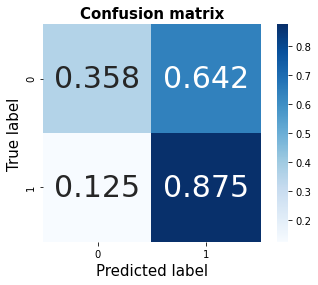

In [82]:
cm = confusion_matrix(y_test, y_pred_xgb_best)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

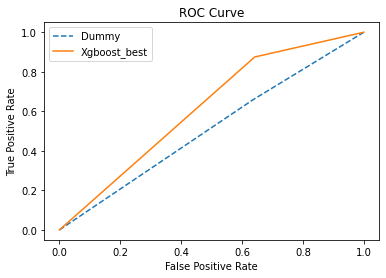

AUC(Dummy) = 0.51
AUC(Xgboost)= 0.69


In [83]:
# Plot the ROC curve
fpr_xgb_best, tpr_xgb_best, thresholds_xgb_best = roc_curve(y_test, y_pred_xgb_best)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_xgb_best, tpr_xgb_best, linestyle='-', label='Xgboost_best')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_best_prob = xgboost_best.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_best_prob[:,1]):.2f}")

## AdaBoost

In [84]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.56      0.36      0.44       508
           1       0.71      0.85      0.78       951

    accuracy                           0.68      1459
   macro avg       0.64      0.61      0.61      1459
weighted avg       0.66      0.68      0.66      1459



In [85]:
fbeta_score(y_test, y_pred_ada, beta=0.5)

0.7375705700236751

Text(0.5, 1.0, 'Confusion matrix')

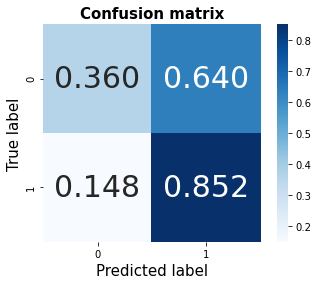

In [86]:
cm = confusion_matrix(y_test, ada.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

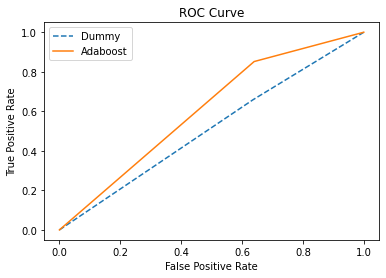

AUC(Dummy) = 0.51
AUC(Adaboost)= 0.68


In [88]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

### Randomsearch

In [139]:
ada_grid = dict()
ada_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
ada_grid['n_estimators'] = [100, 200, 250, 300, 500]

model = AdaBoostClassifier()
grid = ada_grid
    
# run randomized search and optimize for fhalf_scorer
ada_rdm = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs, cv=c)
search = ada_rdm.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   28.5s finished


In [140]:
print(search.best_params_)

{'n_estimators': 250, 'learning_rate': 0.4}


{'learning_rate': 0.1, 'n_estimators': 500}

In [141]:
y_pred_ada_rdm = ada_rdm.predict(X_test)

In [142]:
print(classification_report(y_test, y_pred_ada_rdm))

              precision    recall  f1-score   support

           0       0.58      0.34      0.43       508
           1       0.71      0.87      0.78       951

    accuracy                           0.69      1459
   macro avg       0.65      0.60      0.61      1459
weighted avg       0.67      0.69      0.66      1459



In [143]:
fbeta_score(y_test, y_pred_ada_rdm, beta=0.5)

0.7383627608346711

Text(0.5, 1.0, 'Confusion matrix')

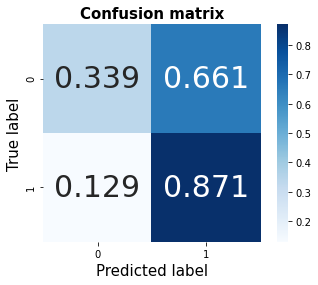

In [144]:
cm = confusion_matrix(y_test, ada_rdm.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

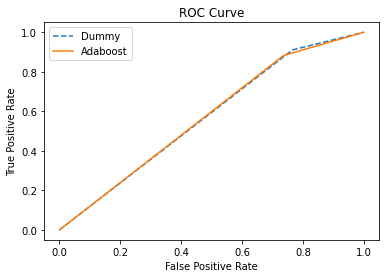

AUC(Dummy) = 0.51
AUC(Adaboost)= 0.68


In [145]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_rdm.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

### Gridsearch

In [146]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

# TODO: Initialize the classifier
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[500],                
              'learning_rate':[0.1, 0.5, 0.15,],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(ada, parameters, fhalf_scorer, cv=c) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_ada = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (ada.fit(X_train, y_train)).predict(X_test)
best_predictions = best_ada.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_ada)


Unoptimized model
------
Accuracy score on testing data: 0.5867
F-score on testing data: 0.6827

Optimized Model
------
Final accuracy score on the testing data: 0.6936
Final F-score on the testing data: 0.7416
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.15, n_estimators=500)


In [147]:
ada_grid = AdaBoostClassifier(base_estimator=DecisionTreeClassifier
                              (max_depth=2,
                               min_samples_split=6),
                              learning_rate=0.1, 
                              n_estimators=500)
ada_grid.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_split=6),
                   learning_rate=0.1, n_estimators=500)

In [148]:
y_pred_ada_grid = ada_grid.predict(X_test)

In [150]:
print(classification_report(y_test, y_pred_ada_grid))

              precision    recall  f1-score   support

           0       0.59      0.37      0.45       508
           1       0.72      0.86      0.78       951

    accuracy                           0.69      1459
   macro avg       0.65      0.62      0.62      1459
weighted avg       0.67      0.69      0.67      1459



In [154]:
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_ada_grid, beta=0.5 ):.2f}')

F-Beta-Score(0.5) =  0.74


Text(0.5, 1.0, 'Confusion matrix')

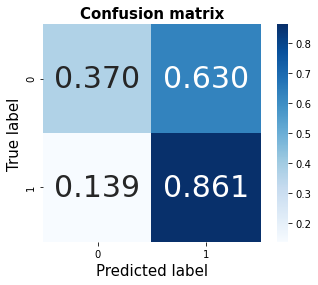

In [152]:
cm = confusion_matrix(y_test, ada_grid.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

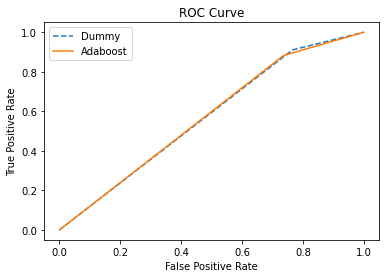

AUC(Dummy) = 0.51
AUC(Adaboost)= 0.67


In [153]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_grid.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

## SVM

### Simple Classifier

In [93]:
svc_model = SVC(C=1, kernel='rbf', probability=True, random_state=rs)
svc = svc_model.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

In [94]:
print(classification_report(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.60      0.28      0.38       508
           1       0.70      0.90      0.79       951

    accuracy                           0.68      1459
   macro avg       0.65      0.59      0.59      1459
weighted avg       0.66      0.68      0.65      1459

[[144 364]
 [ 98 853]]
F-Beta-Score(0.5) =  0.73


Confusion matrix, without normalization
[[129 379]
 [ 91 860]]


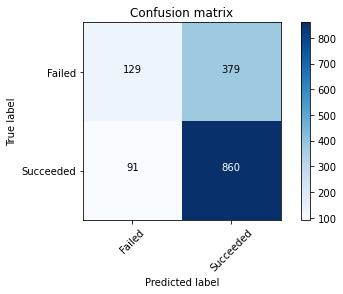

In [97]:
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

In [96]:
y_pred_svc_prob = svc.predict_proba(X_test)
print(f'ROC-AUC-Score = {roc_auc_score(y_test, y_pred_svc_prob[:,1]):.2f}')

ROC-AUC-Score = 0.66


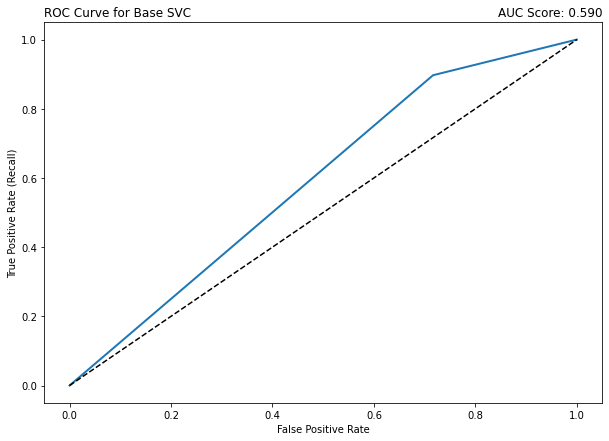

In [98]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc)
auc_score = roc_auc_score(y_test, y_pred_svc)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Base SVC', loc='left')
plt.title(f'AUC Score: {auc_score:.3f}', loc='right');

### Optimize Model

In [99]:
grid_svc = {'C': [0.1,1, 10, 50, 100],
             'kernel': ['linear', 'rbf', 'poly','sigmoid'],
             'gamma' : [1, 0.1, 0.01, 0.001]
             }

In [104]:
svc_grid = GridSearchCV(SVC(), 
                        param_grid=grid_svc, 
                        cv=c, 
                        verbose=False, n_jobs=-1,
                        scoring=fhalf_scorer)

In [105]:
svc_grid.fit(X_train, y_train)
y_pred_svc_grid = svc_grid.predict(X_test)
svc_grid.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [106]:
print(svc_grid.best_estimator_)

SVC(C=100, gamma=0.01)


In [108]:
print(classification_report(y_test, y_pred_svc_grid))
print(confusion_matrix(y_test, y_pred_svc_grid))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc_grid, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.51      0.31      0.39       508
           1       0.70      0.84      0.76       951

    accuracy                           0.66      1459
   macro avg       0.61      0.58      0.58      1459
weighted avg       0.63      0.66      0.63      1459

[[158 350]
 [149 802]]
F-Beta-Score(0.5) =  0.72


In [109]:
results = pd.DataFrame(svc_grid.cv_results_)
results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
73,1.993205,0.069172,0.179135,0.007321,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.756017,0.743028,0.732268,0.743771,0.009710,1
57,1.319801,0.091860,0.168026,0.007293,50,0.01,rbf,"{'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}",0.755024,0.739688,0.728525,0.741079,0.010863,2
41,0.764448,0.030172,0.190620,0.006706,10,0.01,rbf,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.745053,0.736797,0.741254,0.741035,0.003374,3
21,0.702613,0.015058,0.223516,0.008323,1,0.1,rbf,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.742422,0.737944,0.735843,0.738736,0.002744,4
77,0.820000,0.058567,0.175387,0.006558,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.730827,0.728324,0.732744,0.730632,0.001810,5


## kNN

### Simple kNN

In [113]:
train_accuracy = []
test_accuracy = []
train_beta = []
test_beta = []

# Probiere Werte für k von 1 bis 10 aus
neighbor_settings = range(1, 20)

for k in neighbor_settings:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_beta.append(fbeta_score(y_test, y_pred, beta=0.5))
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

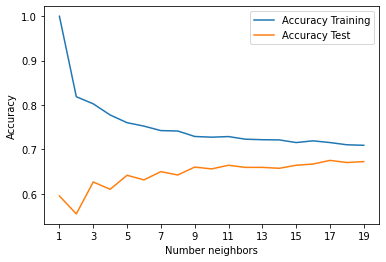

In [114]:
plt.plot(neighbor_settings, train_accuracy, label='Accuracy Training')
plt.plot(neighbor_settings, test_accuracy, label='Accuracy Test')
plt.ylabel('Accuracy')
plt.xlabel('Number neighbors')
plt.legend()
plt.xticks(ticks=list(range(1,21,2)) ,labels=list(range(1,21,2)));

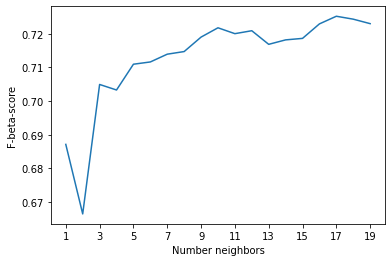

In [115]:
plt.plot(neighbor_settings, train_beta)
plt.ylabel('F-beta-score')
plt.xlabel('Number neighbors')
plt.xticks(ticks=list(range(1,21,2)) ,labels=list(range(1,21,2)));

We take 17 neighbours as best value, for the first simple model.

In [116]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)
y_pred_knn= knn.predict(X_test)

In [117]:
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_knn, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.58      0.23      0.33       508
           1       0.69      0.91      0.79       951

    accuracy                           0.68      1459
   macro avg       0.64      0.57      0.56      1459
weighted avg       0.65      0.68      0.63      1459

[[119 389]
 [ 85 866]]
F-Beta-Score(0.5) =  0.73


In [118]:
y_pred_knn_prob = clf.predict_proba(X_test)
print(f'ROC-AUC-Score = {roc_auc_score(y_test, y_pred_knn_prob[:,1]):.2f}')

ROC-AUC-Score = 0.63


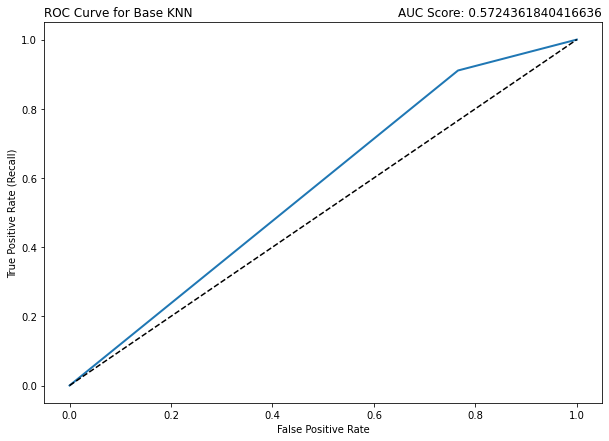

In [119]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
auc_score = roc_auc_score(y_test, y_pred_knn)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Base KNN', loc='left')
plt.title(f'AUC Score: {auc_score}', loc='right');

### Optimize Model

In [120]:
grid_knn = {'n_neighbors' : list(range(1,30)),
             'weights': ['uniform', 'distance'],
             'leaf_size' : list(range(1,20)),
             'metric' : ['euclidean','minkowski','manhattan']
             }

In [121]:
knn_grid_mod = GridSearchCV(KNeighborsClassifier(), 
                        param_grid=grid_knn, 
                        cv=c, 
                        verbose=False, n_jobs=-1,
                        scoring=fhalf_scorer)
knn_grid_mod.fit(X_train, y_train)
y_pred = knn_grid_mod.predict(X_test)


In [122]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.54      0.26      0.36       508
           1       0.69      0.88      0.78       951

    accuracy                           0.67      1459
   macro avg       0.62      0.57      0.57      1459
weighted avg       0.64      0.67      0.63      1459

[[134 374]
 [112 839]]
F-Beta-Score(0.5) =  0.72


In [123]:
knn_grid_mod.best_params_

{'leaf_size': 1,
 'metric': 'euclidean',
 'n_neighbors': 16,
 'weights': 'uniform'}

In [124]:
y_pred_prob = knn_grid_mod.predict_proba(X_test)
print(f'ROC-AUC-Score = {roc_auc_score(y_test, y_pred_prob[:,1]):.2f}')

ROC-AUC-Score = 0.62


## Naive Bayes

### Hyperparameter by default

In [125]:
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

In [126]:
print(classification_report(y_test, y_pred_gnb))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.49      0.31      0.38       508
           1       0.69      0.83      0.75       951

    accuracy                           0.65      1459
   macro avg       0.59      0.57      0.57      1459
weighted avg       0.62      0.65      0.62      1459

F-Beta-Score(0.5) =  0.71


Confusion matrix, without normalization
[[158 350]
 [166 785]]


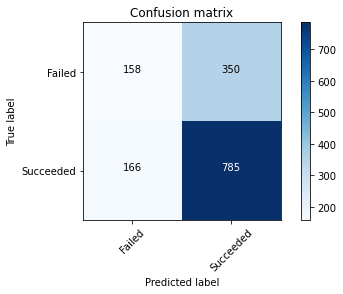

In [127]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

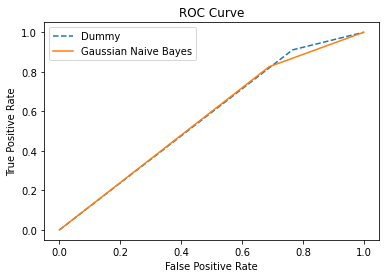

AUC(Dummy) = 0.51
AUC(GNB)= 0.64


In [128]:
# Plot the ROC curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred_gnb)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Gaussian Naive Bayes') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_prob = gnb.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob[:,1]):.2f}")

### Hyperparameter Tuning

In [129]:
# Hyperparameter grid for GridSearch for Naive Bayes
params_grid = {'var_smoothing': np.logspace(1,-9, num=1000)}

# Estimator for use in gridSearch
estimator = GaussianNB()

# Create the gridSearch model
gnb_gs = GridSearchCV(estimator, params_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
gnb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2920 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   13.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00e+01, 9.77e+00, 9.55e+00, 9.33e+00, 9.12e+00, 8.91e+00,
       8.71e+00, 8.51e+00, 8.32e+00, 8.13e+00, 7.94e+00, 7.76e+00,
       7.58e+00, 7.41e+00, 7.24e+00, 7.08e+00, 6.92e+00, 6.76e+00,
       6.60e+00, 6.45e+00, 6.31e+00, 6.16e+00, 6.02e+00...
       2.14e-09, 2.09e-09, 2.04e-09, 2.00e-09, 1.95e-09, 1.91e-09,
       1.86e-09, 1.82e-09, 1.78e-09, 1.74e-09, 1.70e-09, 1.66e-09,
       1.62e-09, 1.59e-09, 1.55e-09, 1.51e-09, 1.48e-09, 1.45e-09,
       1.41e-09, 1.38e-09, 1.35e-09, 1.32e-09, 1.29e-09, 1.26e-09,
       1.23e-09, 1.20e-09, 1.18e-09, 1.15e-09, 1.12e-09, 1.10e-09,
       1.07e-09, 1.05e-09, 1.02e-09, 1.00e-09])},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [130]:
gnb_gs.best_params_

{'var_smoothing': 0.03694601205199302}

In [131]:
best_model_gnb_gs = gnb_gs.best_estimator_

In [132]:
y_pred_gnb_best = best_model_gnb_gs.predict(X_test)
print(classification_report(y_test, y_pred_gnb_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

           0       0.50      0.31      0.38       508
           1       0.69      0.83      0.76       951

    accuracy                           0.65      1459
   macro avg       0.60      0.57      0.57      1459
weighted avg       0.63      0.65      0.63      1459

F-Beta-Score(0.5) =  0.72


Confusion matrix, without normalization
[[158 350]
 [158 793]]


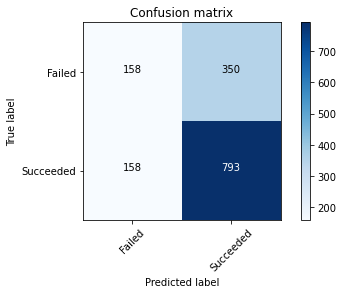

In [133]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

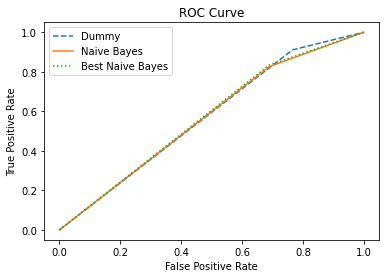

AUC(Dummy) = 0.51
AUC(GNB)= 0.64
AUC(BestGNB)= 0.65


In [134]:
# Plot the ROC curve
fpr_gnb_best, tpr_gnb_best, thresholds_gnb_best = roc_curve(y_test, y_pred_gnb_best)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Naive Bayes') 
plt.plot(fpr_gnb_best, tpr_gnb_best, linestyle=':', label='Best Naive Bayes')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_best_prob = best_model_gnb_gs.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob[:,1]):.2f}")
print(f"AUC(BestGNB)= {roc_auc_score(y_test, y_pred_gnb_best_prob[:,1]):.2f}")

# Overview

In [135]:
models = {"Dummy": [0.66, 0.66, 0.51, 0.56],
          "LogRegres": [0.69, 0.73, 0.69, 0.68],
          "DecisionTree": [0.68, 0.70, 0.60, 0.62],
          "RandomForrest": [0.71, 0.74, 0.68, 0.69 ],
          "AdaBoost": [0.72, 0.743, 0.68, 0.69],
          "XGBBoost": [0.72, 0.745, 0.69, 0.69],
          "SVM": [0.70,0.73,0.66,0.68],
          "KNN": [0.69 ,0.73, 0.62,0.68],
          "GNB": [0.69,0.72,0.65, 0.65]}

In [136]:
overview = pd.DataFrame.from_dict(models, orient='index')
overview.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy"]
overview

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
Dummy,0.66,0.660,0.51,0.56
LogRegres,0.69,0.730,0.69,0.68
DecisionTree,0.68,0.700,0.60,0.62
RandomForrest,0.71,0.740,0.68,0.69
AdaBoost,0.72,0.743,0.68,0.69
XGBBoost,0.72,0.745,0.69,0.69
SVM,0.70,0.730,0.66,0.68
KNN,0.69,0.730,0.62,0.68
GNB,0.69,0.720,0.65,0.65


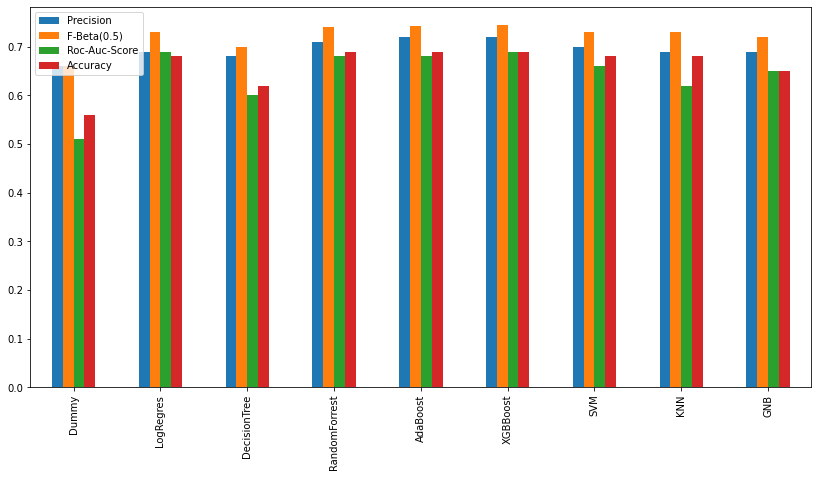

In [137]:
overview.plot(kind='bar', figsize=(14,7));

At this point we drop Naive Bayes and DecisionTreeClassifier. The results are the worst from all.

# Feature Importance

## Logistic Regression

Feature: 0, Score: -0.13758 age
Feature: 1, Score: -0.01085 numb_diagn
Feature: 2, Score: -0.29433 los
Feature: 3, Score: -0.22983 tracheo
Feature: 4, Score: 0.06988 PaO2
Feature: 5, Score: -0.21033 base_excess
Feature: 6, Score: 0.02250 creatinin
Feature: 7, Score: -0.05783 hb
Feature: 8, Score: 0.29823 pH
Feature: 9, Score: -0.23866 FiO2
Feature: 10, Score: -0.15654 PEEP
Feature: 11, Score: 0.03961 SaO2
Feature: 12, Score: 0.03058 blood_pr
Feature: 13, Score: -0.10379 hr
Feature: 14, Score: 0.03306 lactic_acid
Feature: 15, Score: 0.01792 leuko
Feature: 16, Score: -0.00767 mean_insp_pr
Feature: 17, Score: 0.08922 resp_rat
Feature: 18, Score: 0.17142 tidal_vol
Feature: 19, Score: -0.21820 breath_min_vol
Feature: 20, Score: -0.01506 ismale
Feature: 21, Score: -0.07728 icu_CSRU
Feature: 22, Score: -0.10268 icu_MICU
Feature: 23, Score: -0.07106 icu_SICU
Feature: 24, Score: -0.04721 icu_TSICU


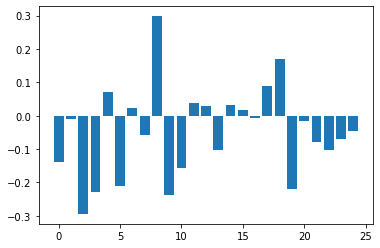

In [138]:
# get importance
importance_logreg = best_model_lr_gs.coef_[0]
# summarize feature importance
for i,v in enumerate(importance_logreg):
	print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i] )
# plot feature importance
plt.bar([x for x in range(len(importance_logreg))], importance_logreg)
plt.show()